# Retail pricing

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#import scipy


import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys, json

from sklearn.preprocessing import  StandardScaler , OneHotEncoder, OrdinalEncoder 
\
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split #
# from sklearn.ensemble import RandomForestRegressor, StackingRegressor

# from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  GradientBoostingRegressor, StackingRegressor

from sklearn.metrics import  mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, PredictionErrorDisplay

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.compose import make_column_transformer
#from imblearn.over_sampling import SMOTE
#from sklearn.impute import KNNImputer

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
 
#from models.models import ModelSequential

#import optuna
#import pickle

# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

#!pip freeze > requirements.txt

In [118]:
from utils.config_reader import config_reader
#from utils.functions import 
from utils.figures import qq_plot, get_ROC_plot,  get_comparison, annotate_scatterplot
#from utils.models_utils import f1, callbacks


# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

## Read files

In [119]:
data = pd.read_csv(config.data_dir + 'retail_price.zip')
data.head()

,product_id,product_category_name,month_year,qty,...,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,...,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,01-06-2017,3,...,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,01-07-2017,6,...,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,01-08-2017,4,...,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,01-09-2017,2,...,45.95,4.0,15.100000,45.95


In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

In [121]:
data

,product_id,product_category_name,month_year,qty,...,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,01-05-2017,1,...,45.95,4.0,15.100000,45.900000
1,bed1,bed_bath_table,01-06-2017,3,...,45.95,4.0,12.933333,45.950000
2,bed1,bed_bath_table,01-07-2017,6,...,45.95,4.0,14.840000,45.950000
3,bed1,bed_bath_table,01-08-2017,4,...,45.95,4.0,14.287500,45.950000
...,...,...,...,...,...,...,...,...,...
672,bed5,bed_bath_table,01-06-2017,10,...,45.95,4.0,12.933333,215.000000
673,bed5,bed_bath_table,01-07-2017,59,...,45.95,4.0,14.840000,209.000000
674,bed5,bed_bath_table,01-08-2017,52,...,45.95,4.0,14.287500,205.000000
675,bed5,bed_bath_table,01-09-2017,32,...,45.95,4.0,15.100000,199.509804


In [122]:
any(data.isna().sum())#.value_counts()

False

> The dataset does not contain missing entries.

# 1. EDA

In [123]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in data.columns if data[s].dtypes in numerics]
cat_features = [s for s in data.columns if data[s].dtypes == 'object' or data[s].dtypes == 'category']
print(num_features)

['qty', 'total_price', 'freight_price', 'unit_price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_score', 'customers', 'weekday', 'weekend', 'holiday', 'month', 'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'lag_price']


In [124]:
#qq_plot(data, num_features[:5], 'unit_price')

### qty

In [125]:
data['qty']

0       1
1       3
2       6
3       4
       ..
672    10
673    59
674    52
675    32
Name: qty, Length: 676, dtype: int64

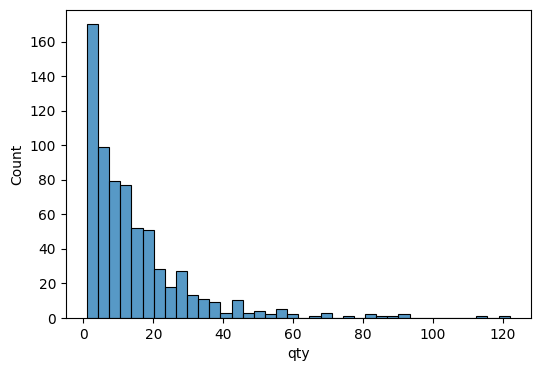

In [126]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data['qty']); #,bins=15

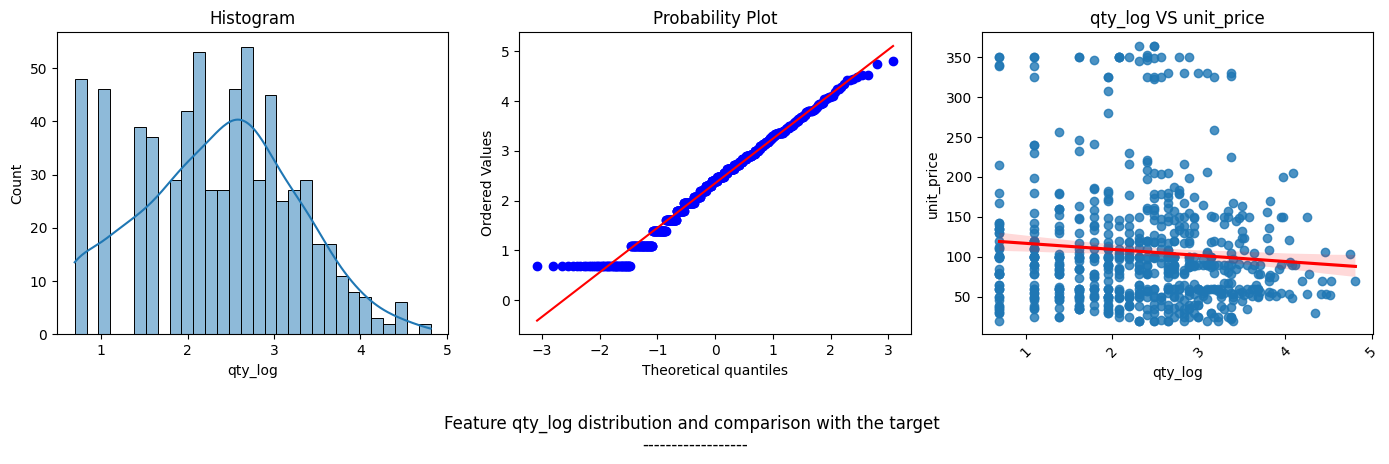

In [127]:
data['qty_log'] = np.log(data['qty'] + 1)
qq_plot(data, ['qty_log'], 'unit_price')

### unit_price (target feature)

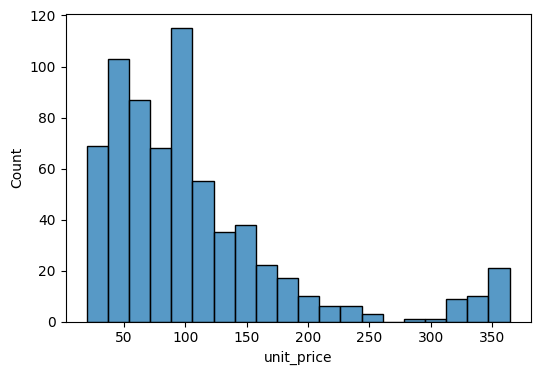

In [128]:
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(data['unit_price']); #,bins=15

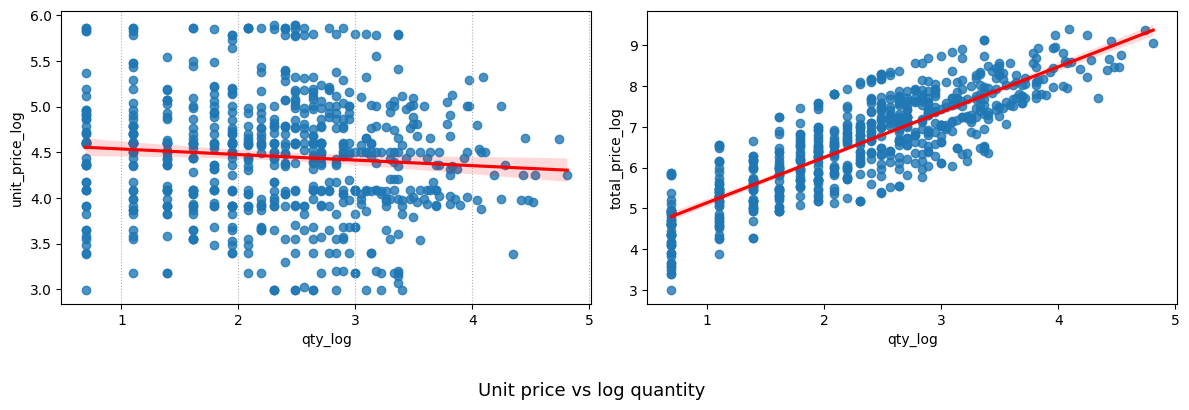

In [129]:
data['total_price_log'] = np.log(data['total_price'])
data['unit_price_log'] = np.log(data['unit_price'])

fig, ax = plt.subplots(1,2, figsize=(12, 4))
#fig = sns.histplot(data['qty_log'], ax=ax[0]); #,bins=15
sns.regplot(data, y='unit_price_log', x='qty_log', ax=ax[0] , line_kws={"color": "red"}) #
sns.regplot(data, y='total_price_log', x='qty_log', ax=ax[1] , line_kws={"color": "red"})
#ax[0].set_yscale('log')

ax[0].xaxis.grid(linestyle=':')
plot_counter=1
fig.suptitle('Unit price vs log quantity ', y=-0.05, fontsize=13) #, loc='right'
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

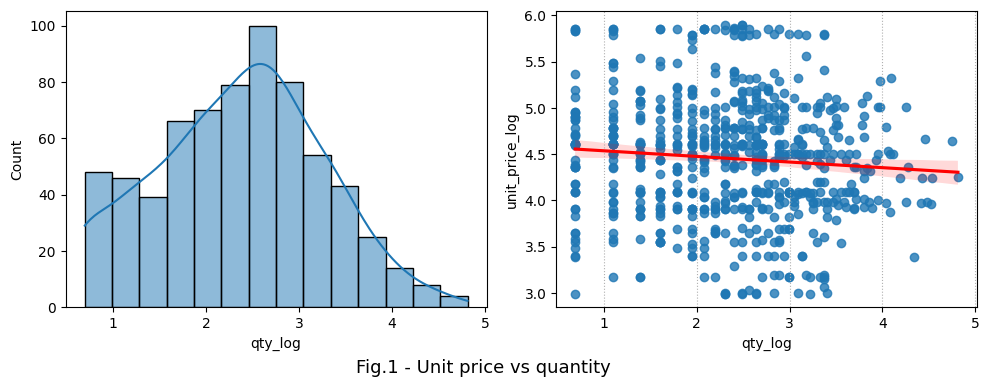

In [130]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
fig = sns.histplot(data['qty_log'], ax=ax[0], kde=True); #,bins=15
fig = sns.regplot(data, y='unit_price_log', ax=ax[1], x='qty_log', line_kws={"color": "red"}) #
ax[1].xaxis.grid(linestyle=':')

plot_counter=1
ax[0].set_title('Fig.1 - Unit price vs quantity ', y=-0.25, fontsize=13, x=1) #
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

> It is essential that unit price is discounted in case of wholesale.

### product_id 

In [131]:
display(f"Number of unique categories: {data['product_id'].nunique()}")
data['product_id'].value_counts()

'Number of unique categories: 52'

health5     20
health7     20
bed2        19
garden1     18
            ..
cool3        7
health10     7
health6      7
bed5         5
Name: product_id, Length: 52, dtype: int64

In [132]:
data[data['product_id']=='bed1']

,product_id,product_category_name,month_year,qty,...,lag_price,qty_log,total_price_log,unit_price_log
0,bed1,bed_bath_table,01-05-2017,1,...,45.90,0.693147,3.827554,3.827554
1,bed1,bed_bath_table,01-06-2017,3,...,45.95,1.386294,4.926166,3.827554
2,bed1,bed_bath_table,01-07-2017,6,...,45.95,1.945910,5.619313,3.827554
3,bed1,bed_bath_table,01-08-2017,4,...,45.95,1.609438,5.213848,3.827554
...,...,...,...,...,...,...,...,...,...
12,bed1,bed_bath_table,01-05-2018,19,...,39.99,2.995732,6.633068,3.688629
13,bed1,bed_bath_table,01-06-2018,5,...,39.99,1.791759,5.298067,3.688629
14,bed1,bed_bath_table,01-07-2018,8,...,39.99,2.197225,5.768071,3.688629
15,bed1,bed_bath_table,01-08-2018,8,...,39.99,2.197225,5.749138,3.669697


In [133]:
temp = data['product_id'].str.split('([A-Za-z]+)', expand=True)#.iloc[:,1] #(\d+)
#display(temp)
data['product_subcategory'] = temp[2].astype('category')
temp[1].value_counts()

garden       160
health       130
watches      103
computers     69
bed           61
cool          57
furniture     48
perfumery     26
consoles      22
Name: 1, dtype: int64

### product_category_name

In [134]:
data['product_category_name'].value_counts()

garden_tools             160
health_beauty            130
watches_gifts            103
computers_accessories     69
bed_bath_table            61
cool_stuff                57
furniture_decor           48
perfumery                 26
consoles_games            22
Name: product_category_name, dtype: int64

In [135]:
data[data['product_category_name']=='watches_gifts']

,product_id,product_category_name,month_year,qty,...,qty_log,total_price_log,unit_price_log,product_subcategory
212,watches2,watches_gifts,01-06-2017,5,...,1.791759,6.671970,5.062532,2
213,watches2,watches_gifts,01-07-2017,6,...,1.945910,6.924563,5.146284,2
214,watches2,watches_gifts,01-08-2017,5,...,1.791759,6.744648,5.135210,2
215,watches2,watches_gifts,01-09-2017,10,...,2.397895,7.380256,5.077671,2
...,...,...,...,...,...,...,...,...,...
647,watches1,watches_gifts,01-05-2018,32,...,3.496508,8.352554,4.886818,1
648,watches1,watches_gifts,01-06-2018,15,...,2.772589,7.636897,4.928847,1
649,watches1,watches_gifts,01-07-2018,2,...,1.098612,5.736572,5.043425,1
650,watches1,watches_gifts,01-08-2018,11,...,2.484907,7.378421,4.980526,1


> This feature duplicates with the previous one so it should be deleted

In [136]:
data['product_category_name'] = data['product_category_name'].astype('category')
data['product_category_name']

0      bed_bath_table
1      bed_bath_table
2      bed_bath_table
3      bed_bath_table
            ...      
672    bed_bath_table
673    bed_bath_table
674    bed_bath_table
675    bed_bath_table
Name: product_category_name, Length: 676, dtype: category
Categories (9, object): ['bed_bath_table', 'computers_accessories', 'consoles_games', 'cool_stuff', ..., 'garden_tools', 'health_beauty', 'perfumery', 'watches_gifts']

### month_year

In [137]:
type(data['month_year'].iloc[1])

str

In [138]:
data['month_year'] = pd.to_datetime(data['month_year'])#.dt.date #, errors='coerce'
data['year'] = pd.to_datetime(data['month_year']).dt.year 
data['month'] = pd.to_datetime(data['month_year']).dt.month
data['day'] = pd.to_datetime(data['month_year']).dt.day
data['month_year']

0     2017-01-05
1     2017-01-06
2     2017-01-07
3     2017-01-08
         ...    
672   2017-01-06
673   2017-01-07
674   2017-01-08
675   2017-01-09
Name: month_year, Length: 676, dtype: datetime64[ns]

In [139]:
data['month_year'].dt.date.unique()

array([datetime.date(2017, 1, 5), datetime.date(2017, 1, 6),
       datetime.date(2017, 1, 7), datetime.date(2017, 1, 8),
       datetime.date(2017, 1, 9), datetime.date(2017, 1, 10),
       datetime.date(2017, 1, 11), datetime.date(2017, 1, 12),
       datetime.date(2018, 1, 1), datetime.date(2018, 1, 2),
       datetime.date(2018, 1, 3), datetime.date(2018, 1, 4),
       datetime.date(2018, 1, 5), datetime.date(2018, 1, 6),
       datetime.date(2018, 1, 7), datetime.date(2018, 1, 8),
       datetime.date(2017, 1, 3), datetime.date(2017, 1, 4),
       datetime.date(2017, 1, 2), datetime.date(2017, 1, 1)], dtype=object)

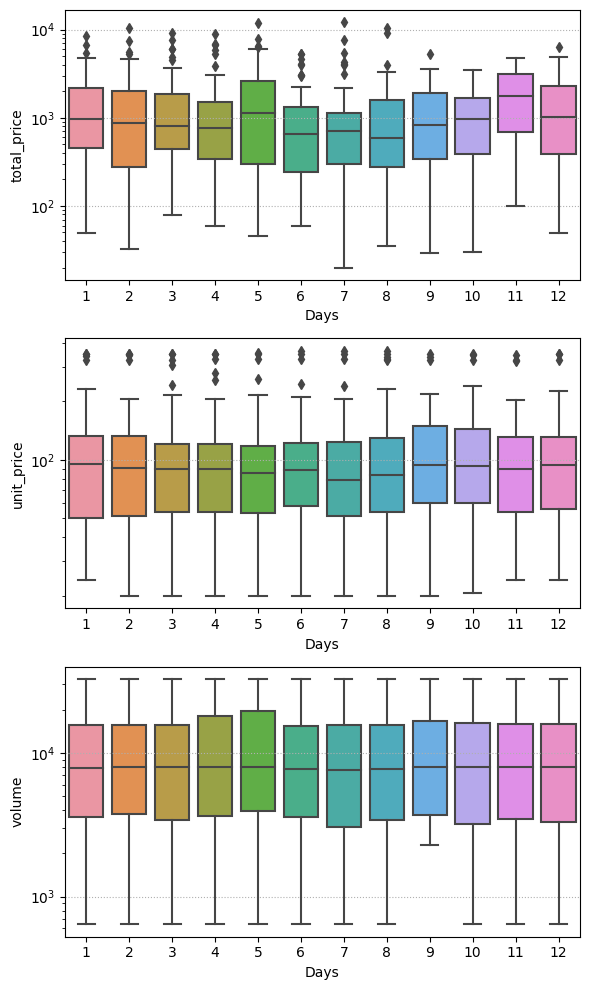

In [140]:
temp = data.groupby(['day'])['total_price', 'unit_price', 'volume'].mean()
plot_counter = 2
fig, ax = plt.subplots(3,1, figsize=(6, 10))

for num, feature in enumerate(['total_price', 'unit_price', 'volume']):
    sns.boxplot(data, x='day', y=feature, ax=ax[num]) #, markers='o'
    ax[num].set_xlabel('Days')
    ax[num].set_ylabel(feature)
    ax[num].yaxis.grid(linestyle=':')
    ax[num].set_yscale('log')
 
    
#ax.set_title(f'Fig.{plot_counter} - Applications, annual default and overdue rates', y=-0.25, fontsize=13, loc='right')
#ax.legend(bbox_to_anchor=(0.4, 1))
#ax2.legend(bbox_to_anchor=(0.4, 0.85))
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

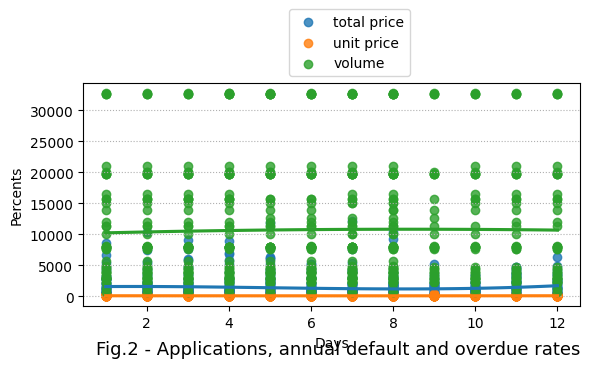

In [141]:
temp = data.groupby(['day'])['total_price', 'unit_price', 'volume'].mean()
plot_counter = 2
fig, ax = plt.subplots(figsize=(6, 4))

sns.regplot(data, x='day', y='total_price', order=3, ci=None, label='total price') #, markers='o'

sns.regplot(data, x='day', y='unit_price', order=2, ci=None, label='unit price')
sns.regplot(data, x='day', y='volume', order=2, ci=None, label='volume')
ax.set_xlabel('Days')
ax.set_ylabel('Percents')
ax.yaxis.grid(linestyle=':')

#ax2 = ax.twinx() 
# ax2 = sns.regplot(app, x=app.index, y=app.values, order=4, ci=None, marker='^', color='red', label='applications ') #'-o' color='red',, size=35
# ax2.set_ylabel('Annual number of applications')
# ax2.set_yscale('log')
ax.set_title(f'Fig.{plot_counter} - Applications, annual default and overdue rates', y=-0.25, fontsize=13, loc='right')
ax.legend(bbox_to_anchor=(0.4, 1))
#ax2.legend(bbox_to_anchor=(0.4, 0.85))
plt.tight_layout()

#plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));

### freight_price

<Axes: >

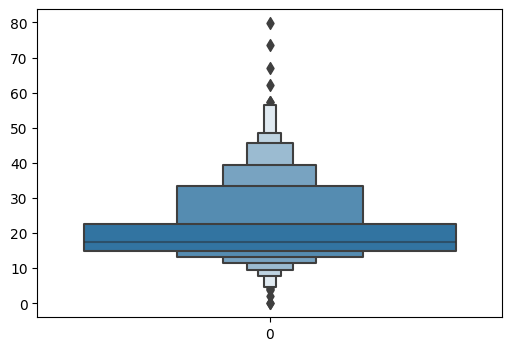

In [142]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxenplot(data['freight_price'])

In [143]:
data['freight_price'].describe()

count    676.000000
mean      20.682270
std       10.081817
min        0.000000
25%       14.761912
50%       17.518472
75%       22.713558
max       79.760000
Name: freight_price, dtype: float64

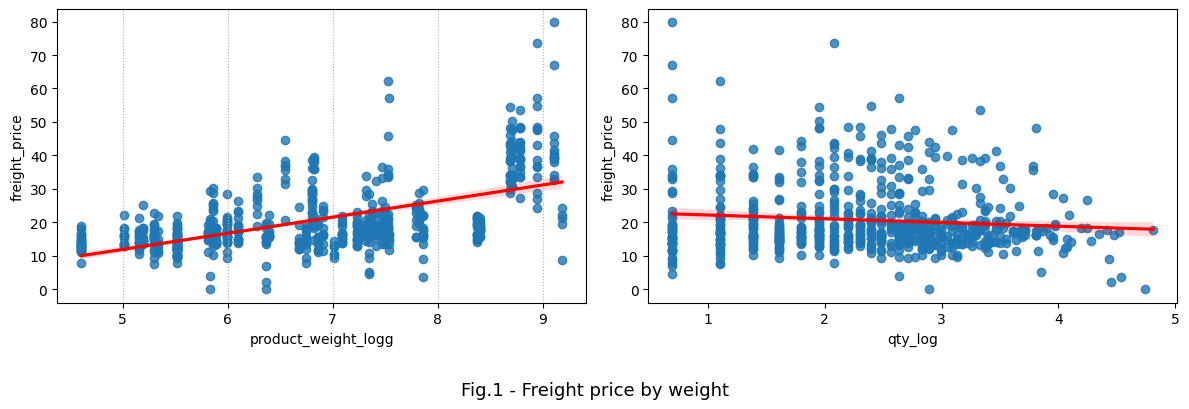

In [144]:
data['product_weight_logg'] = np.log(data['product_weight_g'])

fig, ax = plt.subplots(1,2, figsize=(12, 4))
#fig = sns.histplot(data['qty_log'], ax=ax[0]); #,bins=15
sns.regplot(data, x='product_weight_logg', y='freight_price', ax=ax[0] , line_kws={"color": "red"}) #
sns.regplot(data, x='qty_log', y='freight_price', ax=ax[1] , line_kws={"color": "red"})
#ax[0].set_yscale('log')

ax[0].xaxis.grid(linestyle=':')
plot_counter=1
fig.suptitle('Fig.1 - Freight price by weight', y=-0.05, fontsize=13) #, loc='right'
plt.tight_layout() 

### 'weekend'

In [145]:
data['weekend'].value_counts()

8     323
9     261
10     92
Name: weekend, dtype: int64

In [146]:
data[['weekend']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   weekend  676 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


### weekday

In [147]:
mask = data['product_id']=='bed1'
data[mask][['month_year', 'weekday','weekend', 'holiday']].head(9)

,month_year,weekday,weekend,holiday
0,2017-01-05,23,8,1
1,2017-01-06,22,8,1
2,2017-01-07,21,10,1
3,2017-01-08,23,8,1
4,2017-01-09,21,9,1
5,2017-01-10,22,9,2
6,2017-01-11,22,8,4
7,2017-01-12,21,10,1
8,2018-01-01,23,8,2


<Axes: >

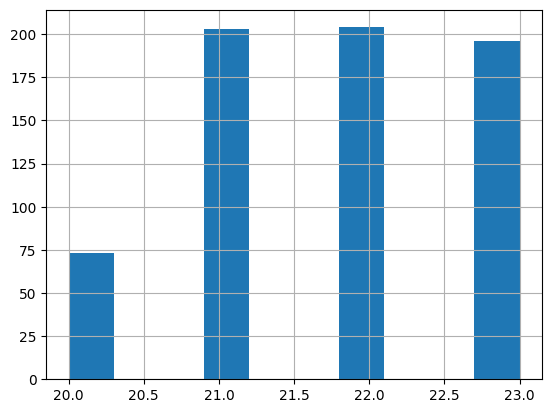

In [148]:
data['weekday'].hist()

In [149]:
data.groupby(['month_year'])['weekday'].agg(['min','max']) #'count'

,min,max
month_year,,
2017-01-01,22,22
2017-01-02,20,20
2017-01-03,23,23
2017-01-04,20,20
...,...,...
2018-01-05,23,23
2018-01-06,21,21
2018-01-07,22,22
2018-01-08,23,23


### product_description_lenght

In [150]:
temp = list(data['product_description_lenght'].unique())
temp = sorted(temp)

print(temp)

[100, 161, 162, 178, 236, 237, 245, 256, 272, 300, 312, 319, 339, 340, 341, 348, 363, 366, 388, 409, 450, 492, 501, 514, 523, 575, 591, 625, 640, 735, 787, 789, 829, 894, 897, 903, 995, 1012, 1257, 1456, 1495, 1536, 1893, 2188, 2644, 3006]


In [151]:
any(data.groupby(['product_id'])['product_description_lenght'].min() == data.groupby(['product_id'])['product_description_lenght'].max())

True

In [152]:
data['product_description_enc'] = pd.cut(data.product_description_lenght, [0,250,500,750,1000,1500,2000,2500,9999], labels = ['<250','500','750','1000','1500','2000','2500','>2500'])
data['product_description_enc']

0      <250
1      <250
2      <250
3      <250
       ... 
672    <250
673    <250
674    <250
675    <250
Name: product_description_enc, Length: 676, dtype: category
Categories (8, object): ['<250' < '500' < '750' < '1000' < '1500' < '2000' < '2500' < '>2500']

In [153]:
data[['product_description_lenght','product_description_enc']].info()
#data.drop(['product_description_lenght'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   product_description_lenght  676 non-null    int64   
 1   product_description_enc     676 non-null    category
dtypes: category(1), int64(1)
memory usage: 6.4 KB


### 'lag_price'

In [154]:
data[['month_year', 'lag_price', 'unit_price']]

,month_year,lag_price,unit_price
0,2017-01-05,45.900000,45.950000
1,2017-01-06,45.950000,45.950000
2,2017-01-07,45.950000,45.950000
3,2017-01-08,45.950000,45.950000
...,...,...,...
672,2017-01-06,215.000000,209.000000
673,2017-01-07,209.000000,205.000000
674,2017-01-08,205.000000,199.509804
675,2017-01-09,199.509804,163.398710


In [155]:
mask = (data['product_id']=='bed1')
print(data[mask].groupby(['month_year'])[['unit_price', 'lag_price']].mean().values)

mask = (data['product_id']=='bed1')
data[mask].groupby(['month_year'])['unit_price'].min()[:-1].values == data[mask].groupby(['month_year'])['lag_price'].max()[1:].values

[[45.95       45.9       ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [45.95       45.95      ]
 [40.53181818 45.95      ]
 [39.99       40.53181818]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.99       39.99      ]
 [39.24       39.99      ]]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [156]:
data['lag_price'].corr(data['unit_price'])

0.9944534285112646

> Let us compare this feature with the unit_price. As it can be seen, they are almost identical.
> Lag price has a very high correlation with the unit_price.  Hence it should be dropped.

### 'product_photos_qty'

In [157]:
data['product_photos_qty'].value_counts()

1    338
2    186
3     65
4     39
6     26
5     15
8      7
Name: product_photos_qty, dtype: int64

In [158]:
temp = data.groupby(['product_id'])['product_photos_qty'].agg(['min','max']).values.flatten()
print(temp)
np.where(temp != temp.round())

[2 2 1 1 1 1 5 5 5 5 1 1 1 1 1 1 1 1 1 1 1 1 4 4 3 3 1 1 1 1 8 8 1 1 1 1 1
 1 6 6 1 1 1 1 1 1 2 2 2 2 1 1 2 2 1 1 2 2 2 2 2 2 2 2 3 3 1 1 6 6 1 1 1 1
 1 1 1 1 2 2 3 3 1 1 2 2 1 1 2 2 3 3 4 4 2 2 1 1 3 3 4 4 1 1]


(array([], dtype=int64),)

> All numbers are integer, and minimums are equal to maximums. Therefore, each category has a dtermined number of photos

### product_weight_g

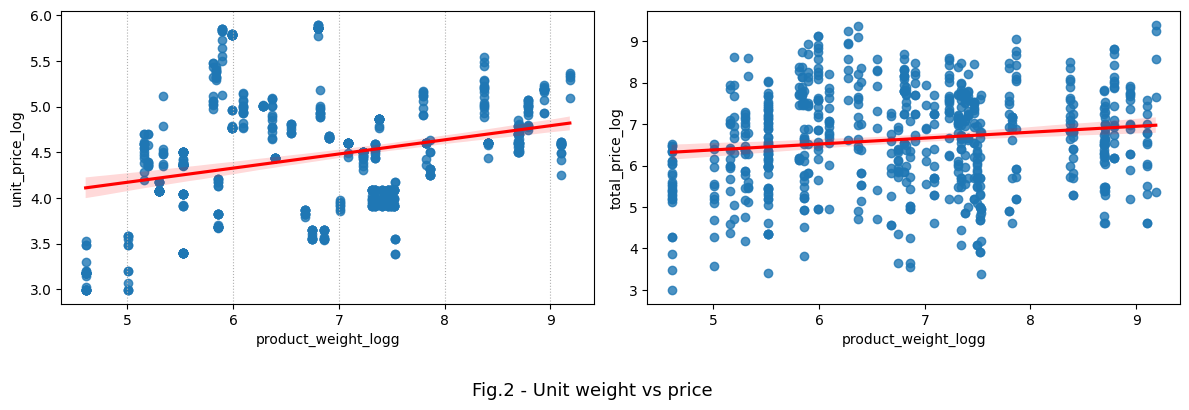

In [159]:
data['product_weight_logg'] = np.log(data['product_weight_g'])

fig, ax = plt.subplots(1,2, figsize=(12, 4))
#fig = sns.histplot(data['qty_log'], ax=ax[0]); #,bins=15
sns.regplot(data, x='product_weight_logg', y='unit_price_log', ax=ax[0] , line_kws={"color": "red"}) #
sns.regplot(data, x='product_weight_logg', y='total_price_log', ax=ax[1] , line_kws={"color": "red"})
#ax[0].set_yscale('log')

ax[0].xaxis.grid(linestyle=':')
plot_counter=1
fig.suptitle('Fig.2 - Unit weight vs price ', y=-0.05, fontsize=13) #, loc='right'
plt.tight_layout() 

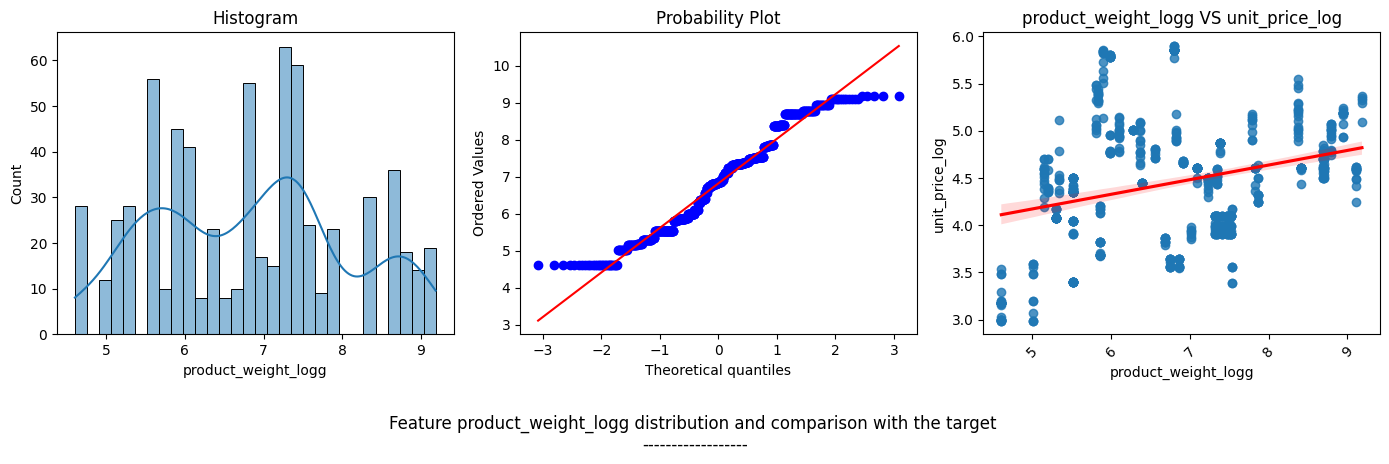

In [160]:
qq_plot(data, ['product_weight_logg'], 'unit_price_log')

In [161]:
data[['product_weight_g']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   product_weight_g  676 non-null    int64
dtypes: int64(1)
memory usage: 5.4 KB


### product_score

In [162]:
data['product_score'].value_counts()

4.2    155
4.1    120
4.3    120
3.9     71
      ... 
3.7     25
3.5     18
3.3     11
4.5     11
Name: product_score, Length: 11, dtype: int64

In [163]:
any(data.groupby(['product_id'])['product_score'].min() == data.groupby(['product_id'])['product_score'].max())

True

In [164]:
data['product_score'] = data['product_score'].astype('category')

### 'ps1'

In [165]:
data['ps1']

0      3.9
1      3.9
2      3.9
3      3.9
      ... 
672    3.9
673    3.9
674    3.9
675    3.9
Name: ps1, Length: 676, dtype: float64

In [166]:
any(data.groupby(['product_id'])['ps1'].min() == data.groupby(['product_id'])['ps1'].max())

True

In [171]:
data.groupby(['product_id'])[['product_score','ps1']]#.min()

In [ ]:
pivot = 

### 'customers'

In [109]:
data['customers']

0       57
1       61
2      123
3       90
      ... 
672     61
673    123
674     90
675     54
Name: customers, Length: 676, dtype: int64

In [110]:
mask = data['product_id']=='bed1'
any(data[mask].groupby(['month_year'])['customers'].min() == data[mask].groupby(['month_year'])['customers'].max())

True

> The feature represents daily demand for every product subcategory

### S

In [111]:
data['s']

0      10.267394
1       6.503115
2      12.071651
3       9.293873
         ...    
672     6.493506
673    38.311688
674    33.766234
675    20.779221
Name: s, Length: 676, dtype: float64

# Feature engineering

In [51]:
# def add_weekend():
#     ['month_year'

# Description

**Features description**

* **product_category_name** - (categorical) - broad group category name
* **product_id** (categorical) - detailed group subcategory name
* **product_description_lenght** (integer) - Number of words in the subcategory description
* **product_score** (float) - user rating of subcategory
* **product_photos_qty** (integer) - number of photos for each subcategory (product_id)
* **customers** (integer) - daily demand for a given subcategory of goods

* **month_year** (string) - sales date in the format (YYYY-MM-DD)
* **qty** (int) - quantity of goods sold
* **unit_price** (float) - price of specific good unit, the target feature
* **freight_price** (float) - price of goods freigh 
* **lag_price** (float) - unit price on the previous day
* **product_weight_g** (integer) - unit weight in grams

* **weekend** (integer) - number of weekends for a given month
* **s** (float) - unknown


## preparation

In [52]:
data.drop(['product_id','month_year', 'qty', 'lag_price', 'unit_price_log', 'total_price_log', 'product_category_name', 'product_subcategory','product_description_lenght', 'product_weight_g'], axis=1, inplace=True) # 

In [53]:
data.columns

Index(['total_price', 'freight_price', 'unit_price', 'product_name_lenght',
       'product_photos_qty', 'product_score', 'customers', 'weekday',
       'weekend', 'holiday', 'month', 'year', 's', 'volume', 'comp_1', 'ps1',
       'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'qty_log', 'day',
       'product_weight_logg', 'product_description_enc'],
      dtype='object')

### Missing values

In [54]:
data.isna().sum().value_counts(ascending=False)

0    27
dtype: int64

### Encoding

In [55]:
X,y =  data.drop(['unit_price'], axis=1), data['unit_price']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in X.columns if X[s].dtypes in numerics]
cat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']
print(num_features)

['total_price', 'freight_price', 'product_name_lenght', 'product_photos_qty', 'customers', 'weekday', 'weekend', 'holiday', 'month', 'year', 's', 'volume', 'comp_1', 'ps1', 'fp1', 'comp_2', 'ps2', 'fp2', 'comp_3', 'ps3', 'fp3', 'qty_log', 'day', 'product_weight_logg']


In [56]:
#cat_features.remove('product_description_enc')
#cat_features.remove('product_score')
#ord_features = ['product_description_enc', 'product_score']

In [242]:
transformer = make_column_transformer(
    (StandardScaler(), num_features),
    #(OneHotEncoder(sparse=False, drop='if_binary'), cat_features), remainder = 'passthrough') 
    (OrdinalEncoder(), cat_features),
    #(OneHotEncoder(sparse=False, drop='if_binary'), cat_features), remainder = 'passthrough'
    )

 
transformer = transformer.fit(X)
results = transformer.transform(X)

results = pd.DataFrame(results, columns=\
    transformer.transformers_[0][1].get_feature_names_out().tolist() \
    + transformer.transformers_[1][1].get_feature_names_out().tolist() \
    #+ transformer.transformers_[2][1].get_feature_names_out().tolist()
    )

results.shape

(676, 26)

In [243]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(results, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))


Train shape: (540, 26)
Test shape:  (68, 26)
Valid shape: (68, 26)


In [244]:
X_train

,total_price,freight_price,product_name_lenght,product_photos_qty,...,day,product_weight_logg,product_score,product_description_enc
218,-0.311213,-0.365178,-1.457487,0.708681,...,1.791914,-0.595800,5.0,5.0
18,0.313910,1.907341,-1.351260,-0.700344,...,-0.367876,1.870150,6.0,4.0
567,-0.490191,1.330215,0.985749,-0.700344,...,0.557748,1.531021,8.0,2.0
408,-0.733277,-0.853547,1.091976,0.004169,...,0.557748,-1.249343,4.0,4.0
...,...,...,...,...,...,...,...,...,...
106,-0.719733,0.048413,0.560838,-0.700344,...,-0.676418,1.297562,8.0,0.0
270,0.788639,-0.659214,-1.669943,0.708681,...,0.866290,-0.371199,7.0,5.0
435,-0.266536,2.035240,-0.182756,-0.700344,...,-0.059335,1.544679,6.0,2.0
102,-0.421369,-0.544535,0.560838,0.004169,...,-0.984959,-1.066481,8.0,2.0


# 2. Modelling

### Linear regression with Stochastic gradient descent

In [245]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Creation an instance
lin_sgd = linear_model.SGDRegressor(random_state=random_seed)

# Train the Model
lin_sgd.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = lin_sgd.predict(X_train), lin_sgd.predict(X_test)
 

print(f'MSE: {round(mean_squared_error(y_test, y_pred_test),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_test)*100,2)} %')

print("Train R^2: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_pred_test)))

MSE: 1413.09
MAPE: 53.92 %
Train R^2: 0.637
Test R^2: 0.683


In [246]:
print(f'Median abs error: {round(median_absolute_error(y_test, y_pred_test),2)}')

Median abs error: 24.75


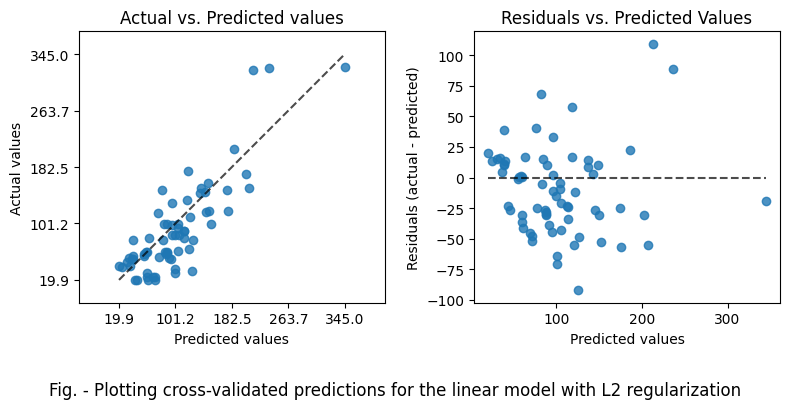

In [247]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions for the linear model with L2 regularization", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');


In [248]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': lin_sgd.coef_}, index=X_train.columns)
coef_df
# add the intercept coefficient
coef_df.loc['INTERCEPT'] = lin_sgd.intercept_
display(coef_df.sort_values('Coefficients',ascending=False))

,Coefficients
INTERCEPT,58.161004
total_price,44.217842
ps1,24.205452
comp_2,20.875699
...,...
fp2,-7.638366
fp1,-9.928581
ps2,-13.869155
qty_log,-31.227960


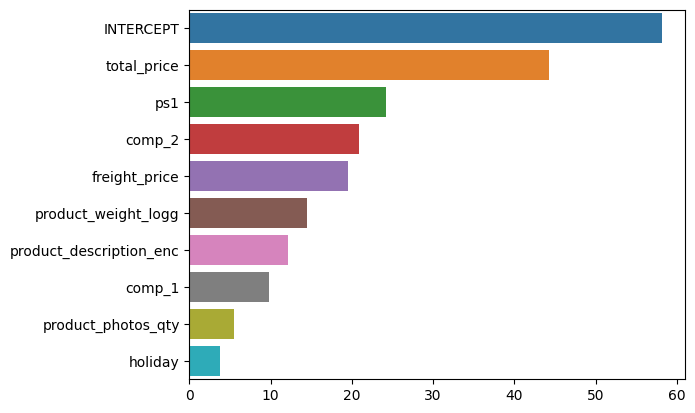

In [249]:
temp = coef_df.sort_values('Coefficients',ascending=False)
sns.barplot(x=temp.values.flatten()[:10], y=temp.index[:10])
plt.show()

> The variance of the model is not constant across various levels of the predicted variable. It means that the model fails to predict low and high interst rates.

## Linear models

In [173]:
# # Creation an instance
# lin_cl = LinearRegression()

# # Train the Model
# lin_cl.fit(X_train, y_train)

# # Predict target values
# y_pred_lin = lin_cl.predict(X_test)

# print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
# print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

### Regularization

In [331]:
# Creation an instance
lasso_lr_poly = linear_model.Lasso(alpha=0.002, random_state=random_seed)

# Train the Model
lasso_lr_poly.fit(X_train, y_train)

# Predict target values
y_pred_lin = lasso_lr_poly.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

MSE: 1293.56
MAPE: 36.77 %


In [332]:
scores = list()
for i in np.linspace(0.001, 0.01, 25):
    # Creation an instance
    lasso_lr_poly = linear_model.Lasso(alpha=i, random_state=random_seed)

    # Train the Model
    lasso_lr_poly.fit(X_train, y_train)

    # Predict target values
    y_pred_lin = lasso_lr_poly.predict(X_test)

    scores.append(np.round(mean_squared_error(y_test, y_pred_lin),2))

best_alpha = np.round(np.linspace(0.001, 0.01, 25)[np.argmin(scores)],4)

# Creation an instance
lasso_lr_poly = linear_model.Lasso(alpha=best_alpha, random_state=random_seed)

# Train the Model
lasso_lr_poly.fit(X_train, y_train)

# Predict target values
y_pred_lin = lasso_lr_poly.predict(X_test)

print(f'MSE: {round(mean_squared_error(y_test, y_pred_lin),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_lin)*100,2)} %')

MSE: 1290.62
MAPE: 36.73 %


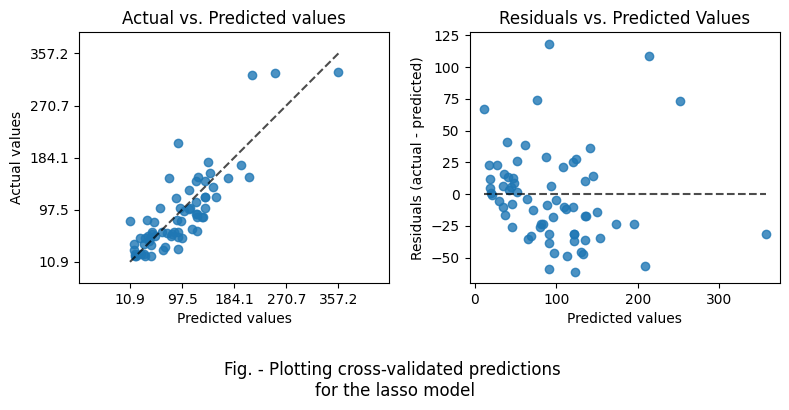

In [333]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_lin,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions \nfor the lasso model", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

### Polynomial

In [334]:
from sklearn.preprocessing import PolynomialFeatures
# Creation an instance
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train)

# Generation of polynomial features for samples
X_train_poly, X_test_poly, X_valid_poly = poly.transform(X_train), poly.transform(X_test), poly.transform(X_valid)


#Выводим результирующие размерности таблиц
print(X_train_poly.shape)
print(X_test_poly.shape)


(540, 434)
(68, 434)


In [335]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Creation an instance
lasso_lr_poly = linear_model.Lasso(alpha=0.005, random_state=random_seed)

# Train the Model
lasso_lr_poly.fit(X_train_poly, y_train)

# Predict target values
y_test_pred_poly = lasso_lr_poly.predict(X_test_poly)

print(f'MSE: {round(mean_squared_error(y_test, y_test_pred_poly),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_test_pred_poly)*100,2)} %')

MSE: 395.51
MAPE: 21.73 %


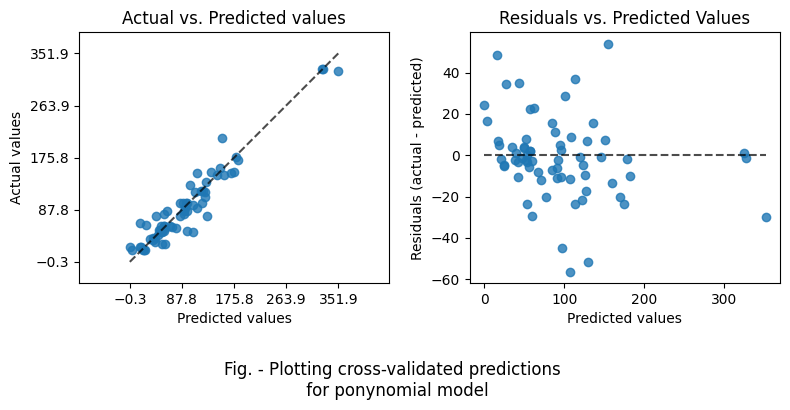

In [336]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred_poly,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_test_pred_poly,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions \n for ponynomial model", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

In [180]:
# # Features and coefficients
# coef_df = pd.DataFrame({'Coefficients': lasso_lr_poly.coef_}, index=lasso_lr_poly._get_param_names())
# coef_df
# # add the intercept coefficient
# coef_df.loc['INTERCEPT'] = lasso_lr_poly.intercept_
# display(coef_df.sort_values('Coefficients',ascending=False))

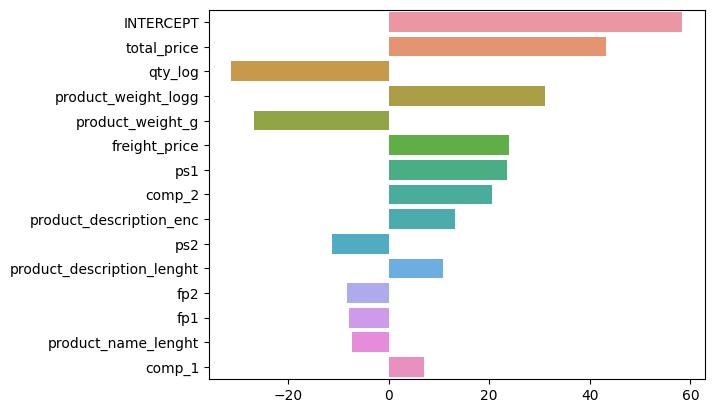

In [337]:
idx = coef_df.sort_values(['Coefficients'], key=abs,ascending=False).index
temp= coef_df.reindex(idx).iloc[:15]#.sort_values('Coefficients', ascending=False)#[:10]
sns.barplot(x=temp.values.flatten(),y=temp.index)
plt.show()

### Elastic net

In [182]:
from sklearn.linear_model import ElasticNet


# Creation an instance
elnet = ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=10000, random_state=random_seed)

# Train the Model
elnet.fit(X_train_poly, y_train)

# Predict target values
y_test_pred_poly = elnet.predict(X_test_poly)

print(f'MSE: {round(mean_squared_error(y_test, y_test_pred_poly),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_test_pred_poly)*100,2)} %')

MSE: 235.15
MAPE: 16.52 %


### Gradient boosting

In [183]:
gbr_cl = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=300,
    random_state=random_seed 
)
# Model training
gbr_cl.fit(X_train, y_train)

# Predict target values
y_pred_train, y_pred_test = gbr_cl.predict(X_train), gbr_cl.predict(X_test)
 

print(f'MSE: {round(mean_squared_error(y_test, y_pred_test),2)}')
print(f'MAPE: {round(mean_absolute_percentage_error(y_test, y_pred_test)*100,2)} %')

print("Train R^2: {:.3f}".format(r2_score(y_train, y_pred_train)))
print("Test R^2: {:.3f}".format(r2_score(y_test, y_pred_test)))

MSE: 44.23
MAPE: 4.79 %
Train R^2: 1.000
Test R^2: 0.990


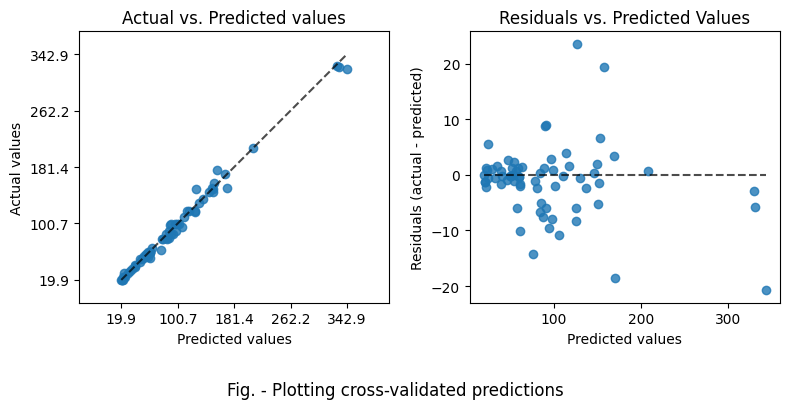

In [184]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="actual_vs_predicted",
    subsample=100,
    ax=ax[0],
    random_state=0,
)
ax[0].set_title("Actual vs. Predicted values")

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred=y_pred_test,
    kind="residual_vs_predicted",
    subsample=100,
    ax=ax[1],
    random_state=0,
)
ax[1].set_title("Residuals vs. Predicted Values")
fig.suptitle("Fig. - Plotting cross-validated predictions", y=-0.05)
plt.tight_layout()

#plt.savefig('../figures/fig_9.png');

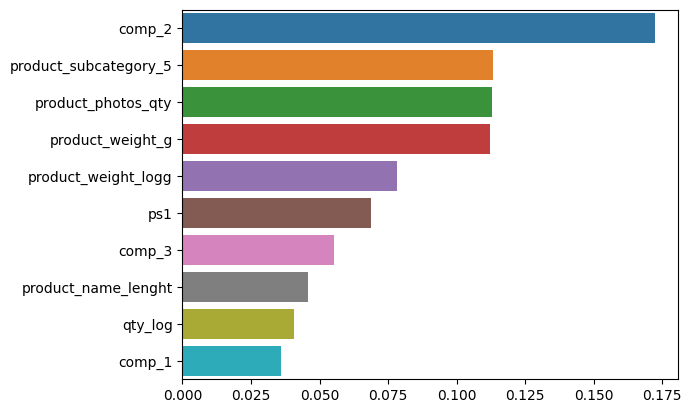

In [185]:
# Features and coefficients
coef_df = pd.DataFrame({'Coefficients': gbr_cl.feature_importances_}, index=gbr_cl.feature_names_in_)
#display(coef_df.sort_values('Coefficients',ascending=False))
temp = coef_df.sort_values('Coefficients', ascending=False).iloc[:10]
sns.barplot(x=temp.values.flatten(), y=temp.index)
plt.show()

In [186]:
# correlation scores with the dependent variable
corr_df = X.corrwith(data['int_rate'], method='pearson')
corr_df = pd.DataFrame({'corr_value':corr_df}).iloc[:7]

corr_df.sort_values(by='corr_value', key=abs, ascending=False, inplace=True)#.round(2).to_dict()

plot_counter = 12
fig, ax = plt.subplots(figsize=(8, 4))
hist = sns.barplot(corr_df, x='corr_value' , y=corr_df.index, width=0.6);

hist.set(xlabel='Correlation coefficient', ylabel='Features')
ax.set_title(f'Fig.{plot_counter} - Interest rate factors', y=-0.3);
#major_ticks = np.linspace(-0.1, 0.1, 3)
#ax.set_xticks(major_ticks)
ax.xaxis.grid(linestyle='--')
plt.tight_layout()

plt.savefig(os.path.join(path_figures + f'fig_{plot_counter}.png'))

KeyError: 'int_rate'

## Model comparison

In [ ]:
# Save model to the given path in the pkl format
model_name = 'gbr_cl'
full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
#models_dict.update({'Revenue_CLoans':model_name})

with open(full_path, 'wb') as f:
    pickle.dump(gbr_cl, f)

In [ ]:
data.head(1)

,loan_amnt,funded_amnt,funded_amnt_inv,term,...,annual_inc_log,source_verified,income_verified,credit_since
782893,25000.0,25000.0,25000.0,36_m,...,12.611538,1,1,20


## Models Comparison

In [ ]:
# # Save model to the given path in the pkl format
# model_name = 'gbr_cl'
# full_path = os.path.join(config.path_models, model_name + '.pkl') #'.pkl'
# #models_dict.update({'Revenue_CLoans':model_name})

# with open(full_path, 'wb') as f:
#     pickle.dump(gbr_cl, f)

## Other

### Gradient boosting + Optuna

In [ ]:
def optuna_gb(trial):
    # set dimensions
    n_estimators = trial.suggest_int('n_estimators', 300, 350, 1)
    max_depth = trial.suggest_int('max_depth', 5, 10, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 5, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1)
    
    # model creation 
    model = GradientBoostingClassifier(
      n_estimators=n_estimators,
      learning_rate=learning_rate,
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=random_seed)
    
    # training
    model.fit(X_train, y_train)
    y_pred = np.round(model.predict_proba(X_test)[:,1])
    F1_score = f1_score(y_test, y_pred)
    roc_score = roc_auc_score(y_test, y_pred)
    
    return F1_score, roc_score

#%%time
sampler = TPESampler(seed=random_seed) # fix random seed

# create study set
study = optuna.create_study(study_name="GBClassifier", directions=["maximize", "maximize"], sampler=sampler)
# try multiple times
study.optimize(optuna_gb, n_trials=5)
clear_output(wait=False)

optuna.visualization.plot_pareto_front(study, target_names=["F1_score", "roc_score"])

In [ ]:
print(f"Number of trials on the Pareto front: {len(study.best_trials)}")

best_hyperparameters = max(study.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest accuracy: ")
#print(f"\tnumber: {best_hyperparameters.number}")
print(f"\tparams: {best_hyperparameters.params}")
#print(f"\tvalues: {best_hyperparameters.values}")

Number of trials on the Pareto front: 1
Trial with highest accuracy: 
	params: {'n_estimators': 319, 'max_depth': 10, 'min_samples_leaf': 4, 'learning_rate': 0.0638792635777333}


              precision    recall  f1-score   support

           0       0.95      0.77      0.85      4878
           1       0.80      0.95      0.87      4701

    accuracy                           0.86      9579
   macro avg       0.87      0.86      0.86      9579
weighted avg       0.88      0.86      0.86      9579

roc_auc:  0.922


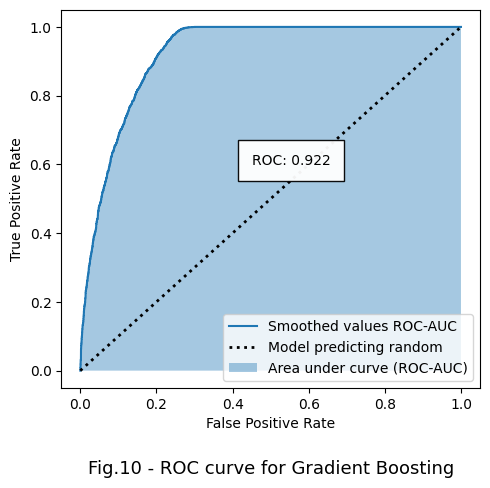

In [ ]:
# Apply best parameters
gb_opt_cl = GradientBoostingClassifier(**best_hyperparameters.params, random_state=random_seed) #study.best_params
gb_opt_cl.fit(X_train, y_train)

# Predict target values
y_pred_gb_optu = gb_opt_cl.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred_gb_optu))

# Save results
models_dict.update({'g_boosting_opt':gb_opt_cl})

get_ROC_plot(gb_opt_cl, X_test, y_test, 'Gradient Boosting', plot_counter=10)  # + Optuna for CL

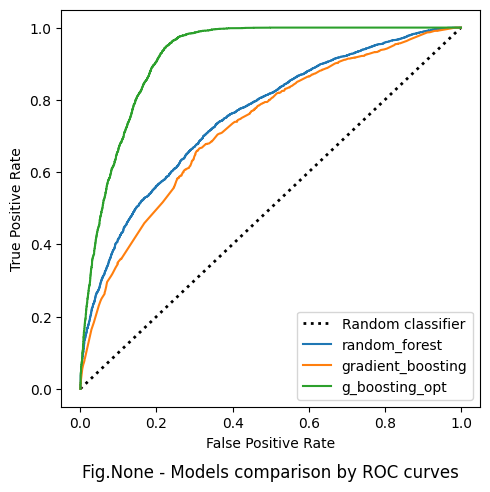

In [ ]:
get_comparison(models_dict, X_test, y_test)

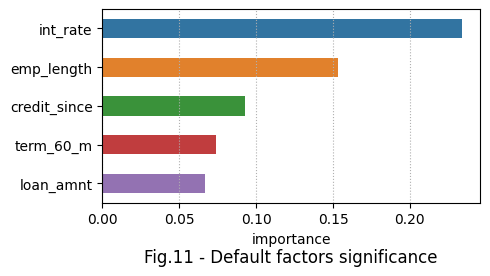

In [ ]:
factors = pd.DataFrame({'importance':gb_opt_cl.feature_importances_}, index=X_train.columns).sort_values(by='importance', ascending=False).iloc[:5]

plot_counter=11

# display first 7 most significant features
fig, ax = plt.subplots(figsize=(5, 3))
sns.barplot(factors, x='importance', y=factors.index, width=0.5)
ax.set_title(f'Fig.{plot_counter} - Default factors significance', y=-0.35); 
plt.tight_layout()
ax.xaxis.grid(linestyle=':');

plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'))

# 3. Interest rate modelling

### Check for multicollinearity

In [ ]:
X, y = data_copy.drop(['int_rate','loan_status', 'sub_grade'], axis=1), np.log(data_copy['int_rate'])  #, , np.log(data['int_rate'] # 'grade'

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

num_features = [s for s in X.columns if X[s].dtypes in numerics]
сat_features = [s for s in X.columns if X[s].dtypes == 'object' or X[s].dtypes == 'category']
num_features

transformed_features = X.columns
transformed_features

Index(['loan_amnt', 'term', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc_log', 'purpose', 'pub_rec_bankruptcies', 'credit_since',
       'source_verified', 'income_verified', 'pub_rec'],
      dtype='object')

In [ ]:
transformer1 = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse=False,drop='if_binary'), сat_features), remainder = 'passthrough') 

transformer1 = transformer1.fit(X)
results = transformer1.transform(X)

results = pd.DataFrame(results, columns=transformer1.transformers_[0][1].get_feature_names_out().tolist() + transformer1.transformers_[1][1].get_feature_names_out().tolist())

# save columns for later usage
imputer_columns = results.columns

In [ ]:
# check for missing values
imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(results), columns=imputer_columns)

# check if nan are present in the dataset
for i in X.columns:
    assert X[i].isna().sum()== 0

### Check for multicollinearity

In [ ]:
# select features with correlation coefficient > 0.7
pivot = X.corr()

for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.7 or x == 1) else x)
    
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')

high_correlation_features = list(pivot.columns) # список признаков c высокой корреляцией
pivot 

print('Features with high correlation coef:')
for count, value in enumerate(high_correlation_features, start=1): # list features from 1
    print(count, value)

Features with high correlation coef:
1 home_ownership_MORTGAGE
2 home_ownership_RENT
3 pub_rec_bankruptcies_1
4 pub_rec_1


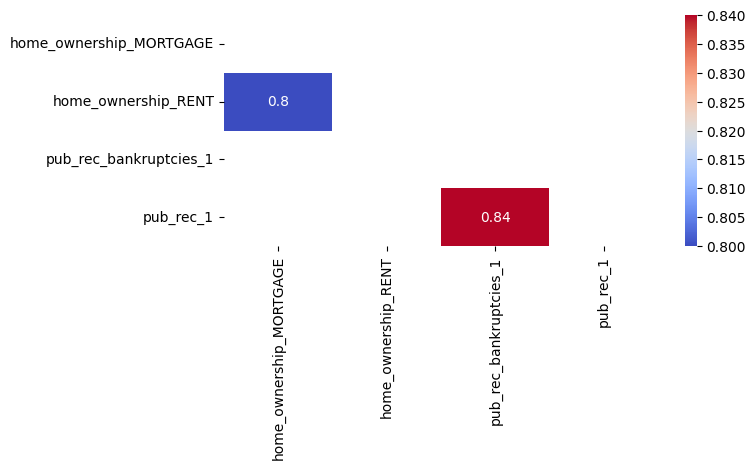

In [ ]:
# heatmap
fig = plt.figure(figsize=(7, 3))
matrix = np.triu(pivot)
sns.heatmap(round(abs(pivot), 2), annot=True, cmap= 'coolwarm', mask=matrix);

In [ ]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (47868, 28)
Test shape:  (5984, 28)
Valid shape: (5984, 28)


In [ ]:
X.head(2)

,loan_amnt,emp_length,annual_inc_log,credit_since,...,pub_rec_bankruptcies_1,source_verified_1,income_verified_1,pub_rec_1
0,0.649080,1.134998,2.348576,4.737288,...,0.0,0.0,0.0,0.0
1,-0.677496,1.134998,0.257095,0.625482,...,0.0,1.0,1.0,0.0


In [ ]:
corr_df.sort_values(by='corr_value', key=abs, ascending=False).index

Index(['emp_length', 'loan_amnt', 'credit_since', 'annual_inc_log',
       'term_60_m', 'emp_title_executive', 'emp_title_employee'],
      dtype='object')

# 4. Expected revenue estimation 

In [ ]:
# current clients
data_c = current.copy() 

def dataset_preprocessing(data:pd.DataFrame)->pd.DataFrame:
    data = data[selected_cols]
    
    data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.date
    data['issued_year'] = pd.to_datetime(data['issue_d'], errors='coerce').dt.year
    data['term'] = data['term'].replace({' 36 months': '36_m', ' 60 months': '60_m'})
    
    # employment length
    data['emp_length'] = data['emp_length'].apply(lambda x: str(x).replace('+ years', '')\
        .replace(' years', '').replace('< 1 year', '0')).replace('1 year', '1').replace('nan','-1').astype('int')
    data['emp_length'].replace(-1, 0, inplace=True)
    # professions
    data['emp_title'] = data['emp_title'].apply(str).str.strip()
    data['emp_title'] = data['emp_title'].apply(get_professions)
    
    # home ownership
    data['home_ownership'] = data['home_ownership'].apply(lambda x: x if x in ['MORTGAGE','RENT', 'OWN'] else 'OTHER').astype('category')
    
    
    # logarythm of the income
    data['annual_inc_log'] = data['annual_inc'].apply(lambda x: np.log(x) if x > 0  else 0)

    # binarization of the verrification status
    data['source_verified'] = data['verification_status'].apply(lambda x: 1 if x=='Source Verified' else 0).astype('category')
    data['income_verified'] = data['verification_status'].apply(lambda x: 1 if x==' Verified' or x=='Source Verified' else 0).astype('category')
    
    # purpose
    data['purpose'] = data['purpose'].apply(get_purpose)
    
    # bankruptcies
    data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].apply(lambda x: 0 if x==0 else 1).astype('category')

    # credit history
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.date
    data['credit_since'] = data['issued_year'] - pd.to_datetime(data['earliest_cr_line'], errors='coerce').dt.year
    
    # Number of derogatory public records
    data['pub_rec'] = data['pub_rec'].apply(lambda x: 0 if x==0 else 1).astype('category')

    data.drop(['annual_inc', 'verification_status', 'installment'],axis=1, inplace=True) #'issue_d'
    
    return data #[selected_features]

data_c = dataset_preprocessing(data_c)
data_c = data_c[selected_features]
data_c.columns

Index(['loan_amnt', 'term', 'int_rate', 'sub_grade', 'emp_title', 'emp_length',
       'loan_status', 'home_ownership', 'annual_inc_log', 'purpose',
       'pub_rec_bankruptcies', 'credit_since', 'source_verified',
       'income_verified', 'pub_rec'],
      dtype='object')

In [ ]:
data_c = data_c[selected_features]
print(data_c.shape)

temp = transformer.transform(data_c)

# apply all preprocessings
data_c = pd.DataFrame(temp, columns=transformer.transformers_[0][1].get_feature_names_out().tolist() + transformer.transformers_[1][1].get_feature_names_out().tolist())
print(data_c.shape)

(38550, 15)
(38550, 64)


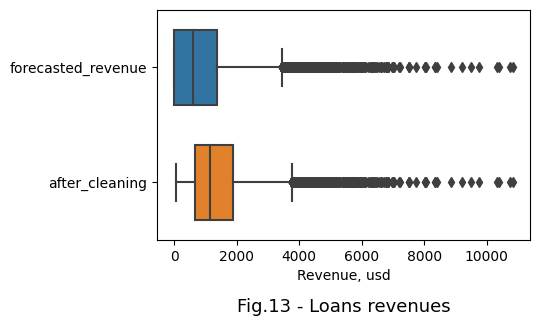

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5.5, 3.5))
fig = sns.boxplot(data=result[['forecasted_revenue','after_cleaning']], orient='h',  width=.65)

plot_counter = 13
 
ax.set_xlabel('Revenue, usd')
#ax.set_ylabel('Scenario')
ax.set_title(f'Fig.{plot_counter} - Loans revenues', y=-0.35, fontsize=13) #, loc='right'
['Current', 'Proposed']
#ax.set_xscale('log')
 
#ax.set_xlim([0,200000])
plt.tight_layout()
plt.savefig(os.path.join(path_figures, f'fig_{plot_counter}.png'));